# Building Topic Model Metrics with Demographic Breakdowns

## Imports

In [7]:
# To store data
import pandas as pd

# To do linear algebra
import numpy as np



# To create models
import sklearn
from sklearn import naive_bayes
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

# To search directories
import os

# To use regex
import re

# To get punctuation
import string

# To parse html
from bs4 import BeautifulSoup

# To get progression bars
from tqdm import tqdm

# To measure time
from time import time

# To get simple counters
from collections import Counter

# To process natural language
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# To use sparse matrices
from scipy.sparse import csr_matrix

# To create plots
import matplotlib.pyplot as plt

#language detection
from langdetect import detect

#FB API
import json
import requests
from facebook_business.api import FacebookAdsApi
from facebook_business import adobjects
from facebook_business.adobjects.adaccount import AdAccount
from facebook_business.adobjects.adcreative import AdCreative
from facebook_business.adobjects.ad import Ad

#dealing with json
from pandas.io.json import json_normalize

#math
import math

## Getting and Processing Data

In [8]:
#as a function:
def getLang(text):
    lang = []
    for i, line in enumerate(text):
        lang.insert(i,detect(line));
    langSeries = pd.Series(lang)
    langSeries.index = list(text.index)
    langSeries = langSeries.rename('lang')
    bod = pd.DataFrame(text)
    bodDF = pd.concat([bod,langSeries], axis=1)
    return bodDF, langSeries;

### Reading in ad spreadsheets

#### First, ad attributes...

In [51]:
th_all = pd.read_excel('THads_attributes_all.xlsx')

In [52]:
th_all_dropped = th_all.dropna(subset=['Body'])

Adding in years and months from the ad set start date -- we might need them!

In [53]:
th_all_dropped.loc[:,'year'] = pd.DatetimeIndex(th_all_dropped["Ad Set Time Start"]).year
th_all_dropped.loc[:,'month'] = pd.DatetimeIndex(th_all_dropped["Ad Set Time Start"]).month

c:\users\chris boulos\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\chris boulos\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [54]:
th_all_body = th_all_dropped['Body']

In [55]:
th_all_body_lang, langSeries = getLang(th_all_body)

Use below for new stuff

In [ ]:
aPATH = './'

#### Then ad results.

In [57]:
bd = pd.read_excel('THads_results_seg.xlsx')

In [58]:
bd.columns

Index(['Ad Id', 'Ad Name', 'Age', 'Gender', 'Result Type', 'Results', 'Reach',
       'Impressions', 'Cost per Result', 'Amount Spent', 'Link Clicks',
       'Objective', 'Cost per Post Engagement', 'Unique Link Clicks',
       'Cost per Unique Click (All)', 'Cost per Unique Link Click',
       'CPC (Cost per Link Click)', 'CPC (All)', 'CTR (All)',
       'Post Engagement', 'Unique CTR (All)',
       'Unique CTR (Link Click-Through Rate)', 'Result Rate',
       'Website Purchase ROAS (Return on Ad Spend)',
       'Cost per Website Conversion'],
      dtype='object')

In [59]:
bd.columns = ['AdID', 'Ad Name', 'Age', 'Gender', 'ResultType', 'Results', 'Reach',
       'Impressions', 'CPR', 'AmountSpent', 'Clicks_links',
       'Objective', 'CostPerEngagement', 'Clicks_links_unique',
       'CPC_unique_all', 'CPC_links_unique',
       'CPC_links', 'CPC_all', 'CTR_all',
       'PostEngagement', 'CTR_unique_all',
       'CTR_links_unique', 'ResultRate',
       'ROAS',
       'CostperWebConv']

### Preparing for topics

This is how many ads are done by language

In [60]:
th_all_body_lang.groupby('lang').count()

,Body
lang,
de,341
en,3571
es,321
fr,878
it,348
ja,2
sv,7


We're only going to look at English counts for now.

In [61]:
bodyENG = th_all_body_lang[th_all_body_lang['lang'] == 'en']

Getting language output attached to the ad copy for processing

In [62]:
bodyDF = pd.concat([bodyENG,langSeries], axis=1)

## Building the topic modeler

First building the stop words, words we don't necessarily want in our analysis.

In [63]:
sw = stopwords.words("english")

In [64]:
sw.extend(
    ('www',
    'hope',
    'thetomhope',
    'com',
    'bit',
    'ly',
    'tom',
     'handcrafted',
     'bracelet',
     'bracelets',
    'https',
    'bio',
    'find',
    'tomhope',
     'http',
     'favorite',
     'favourite',
    '__',
    '00',
    '10',
    '11',
    '12',
    '13',
    '14',
    '15')
    )

In [65]:
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Topic Model is built here...

In [66]:
no_features = 350

In [67]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df=5, strip_accents="unicode",max_features=no_features, stop_words=sw, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(bodyENG["Body"].values.astype('U'))
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.80, min_df=5, strip_accents="unicode", max_features=no_features, stop_words=sw, ngram_range=(1,2))
tf = tf_vectorizer.fit_transform(bodyENG["Body"].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()

In [68]:
tf_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=350, min_df=5,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'find', 'tomhope', 'http', 'favorite', 'favourite', '__', '00', '10', '11', '12', '13', '14', '15'],
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [69]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 7

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)


### Presenting Topics

In [70]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 5
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
test time test stand stand test sweden stand
Topic 1:
love symbol commitment symbol love love commitment
Topic 2:
details style details style remember style remember
Topic 3:
inspired oceans oceans oceans travelers travelers inspired
Topic 4:
today get get today free shipping
Topic 5:
one black one check triple triple black
Topic 6:
passion passion visit visit link link passion details
Topic 0:
test time test stand stand test time
Topic 1:
love symbol commitment symbol love love commitment
Topic 2:
one get make visit sure
Topic 3:
details style style details anchor see
Topic 4:
look courtesy visit photo take
Topic 5:
today get get today free shipping
Topic 6:
new black triple triple black today


In [71]:
lda_Z = lda.fit_transform(tf)


In [72]:
lda_Z[0]

array([0.01298701, 0.01298805, 0.01300222, 0.92198217, 0.01299785,
       0.01298704, 0.01305567])

In [73]:
topic = pd.Series(np.argmax(lda_Z, axis=1))

In [74]:
topic.index = list(bodyENG.index)
topic = topic.rename('topic')

In [75]:
bodyTopicENG = pd.concat([bodyENG,topic], axis=1)

In [76]:
bodyTopicENG[bodyTopicENG['topic']==1]

,Body,lang,topic
3,Travel in style. Share your look by tagging #t...,en,1
4,Anchor your love! Find the perfect pieces for ...,en,1
5,"Follow us for exclusive offers, giveaways and ...",en,1
19,Follow @thetomhope so you don't miss out on ex...,en,1
21,“Friends are the family you choose”. Share the...,en,1
27,"Share the symbol of hope, love, and commitment...",en,1
28,"Share the symbol of hope, love, and commitment...",en,1
36,"Share the symbol of hope, love, and commitment...",en,1
37,"Share the symbol of hope, love, and commitment...",en,1
42,"Share the symbol of hope, love, and commitment...",en,1


Doing some cleaning

In [77]:
adsTopic = pd.concat([th_all_dropped,bodyTopicENG.topic],axis=1, join='inner')

In [78]:
adsTopic.rename({'Ad ID':'AdID'},axis=1,inplace=True)

In [79]:
adsTopic['AdID'] = adsTopic['AdID'].str[2:]

In [80]:
adsTopic.AdID = pd.to_numeric(adsTopic.AdID,errors='coerce')

In [81]:
adsTopic.shape

(3571, 341)

In [83]:
pd.Series(adsTopic.columns)

0                               Campaign ID
1                             Campaign Name
2                           Campaign Status
3                        Campaign Objective
4                               Buying Type
5                      Campaign Spend Limit
6                     Campaign Daily Budget
7                  Campaign Lifetime Budget
8                     Campaign Bid Strategy
9                                      Tags
10                       Product Catalog ID
11                         Campaign Page ID
12                                Ad Set ID
13                        Ad Set Run Status
14              Ad Set Lifetime Impressions
15                              Ad Set Name
16                        Ad Set Time Start
17                         Ad Set Time Stop
18                      Ad Set Daily Budget
19                         Destination Type
20                     Use Dynamic Creative
21                   Ad Set Lifetime Budget
22                              

### Merging in results

Cleaning some stuff in Ads Topic

In [91]:
#result = pd.concat([adsTopic, bd], axis=1, join='inner', join_axes=[adsTopic.AdID])

In [93]:
result = pd.merge(adsTopic,bd,on='AdID')

In [220]:
result.to_csv('result_all.csv')

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6066449059747&h=AQCRAUdwHx1Kpew-' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6066449058947&h=AQDAHMcNJzttj66A' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6066460031347&h=AQAyz8ObTVR2ysBd' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6066457645347&h=AQBGuWhSPhI8B_z9' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6066451890147&h=AQBzKV02hWj-gMf4' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6066527750947&h=AQCTJNN2KhURwxO-' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6066455355947&h=AQB7nUKKSFRppwIC' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6066455356347&h=AQAgxvEqxp2zQnIm' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6066457656147&h=AQBAM68R0ePS3KTo' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6049508734547&h=AQDJbiSbGJvv4TF_' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6049508731747&h=AQDjvMKgDr5Gj_Ic' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6049508736947&h=AQD5uekFgJ-LaBZP' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6069050527347&h=AQAwoaARLpRb5sn1' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6054995940747&h=AQDbVBoZZWxXD1eJ' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6069050528347&h=AQCpGpjxhlHFuoM3' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6053003151947&h=AQB8MYVBdhEVnPlo' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6053003219147&h=AQBtgkpC4yb-xF-G' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6053003120147&h=AQDp2Gm6EWQsBSK6' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6086939779747&h=AQD_Qatazx6EyXHX' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6060704148147&h=AQAhf5P_ITQA7jPN' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6072072657547&h=AQCpJrYbn_9H2L9G' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6064795351147&h=AQAqLBn8DuTD11Cz' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6087638699147&h=AQAbS3vvmICnVNcb' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6063691077347&h=AQBl526Sni6g0HYW' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6063843014347&h=AQDZtPEhUPfNky7k' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6092390315547&h=AQAB-hH3JYwxUjf-' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6092310448347&h=AQC4McGC7u0JK1ZB' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6022180499347&h=AQAwmCSjAwyLDJwE' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6022317549947&h=AQDO9qpwPkfPmfi0' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6022606760747&h=AQAev8gebdCIhR59' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6026315257347&h=AQAymF2kDsjqKkPW' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6026483127347&h=AQDxqI6ssH2PkLTA' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6026881769547&h=AQAcXkd3jZZnN7Zz' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6031153966147&h=AQDlRekkEh2Yhxhg' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6031162228147&h=AQAo2nW0q7RnXATd' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6031262391547&h=AQAr93V5gBzbmjrP' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6033287312147&h=AQDXwYYXYJnXMQ0_' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6033298530147&h=AQCfV89Wvw8HbeEi' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6033523008347&h=AQB6PzPRDvOgA7Yn' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6049566816947&h=AQBDt72VNFbJ0vsg' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6049662839947&h=AQDO8D1zdNGf01CI' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6049876963347&h=AQDZiKjhoL_n8T1L' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6049509031747&h=AQARBNfDNXbpzn2w' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6049509030547&h=AQBmfs7jDkP2q24f' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6049509024947&h=AQBA6M0GT8OJxvtn' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6053003410747&h=AQCRd9zhD-tCDPAJ' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6053003444547&h=AQAT2itj94rbed5c' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6053003391547&h=AQBmVQaoUrGwmffy' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6057456904347&h=AQCQLNQsjbkwRRas' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6057456911347&h=AQDFwPCxRlyqH20R' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6057456915947&h=AQAyK5bb3QSc21Wp' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099342764547&h=AQAQnJHZlyQ9roOa' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099342773947&h=AQCo9Mpxzv-JjToJ' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099342767147&h=AQDNtjYMZ_ueRrMy' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6078661092347&h=AQANCpFYyPMamaHS' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6078661092147&h=AQBdG3NoT6UqXw6Z' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6078661091947&h=AQCAQyPO_XxsP9VL' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081308283547&h=AQDeawe0UA3V0sJq' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081307965147&h=AQCSvprtAaiCMwtc' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081308412547&h=AQBXz1yrj46roYCu' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081308283147&h=AQBVHo9BJF-7ba7A' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081307965547&h=AQCaOzCZCj3CdrFG' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081308412147&h=AQDP1rdrXrDepMPp' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6079457359347&h=AQAYYuZi878ty5PN' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6079457358947&h=AQAUXrG14fxxkeDY' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6079457359547&h=AQAh4O6XVLe-sVge' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6073646007547&h=AQAeR0WzeUMLNucc' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6073646012747&h=AQDPGEiT44xA-Vm7' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6073646007747&h=AQDWHu63n-NVGGuc' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6076635624747&h=AQBfllJlmqnyqtAC' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6056227489547&h=AQCTim5wqz1o3wWp' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6057464473547&h=AQCnxoMCTT_Z7pt3' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6055776568547&h=AQDXeqRoI-aKXk-R' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6084477637947&h=AQAzN7j-clibHpZS' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6083558965547&h=AQATHpJBrXGo88uB' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6028662459947&h=AQAGR3kk0RrF1rLZ' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6093186393347&h=AQBa_BBduEDZ2Ck1' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6058063499147&h=AQAFMtqooJFduBbg' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6082833571147&h=AQBmXKLXfXXm8Ree' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6061145986347&h=AQDB0HtNOygo07ix' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6085962745347&h=AQCEUCpkUXscD9bt' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6086032137747&h=AQByWKwZpRylcNx6' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6077555110347&h=AQBUkDqoAGasAYkN' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6078032491147&h=AQA2XHLRGV9QH4cx' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6068953093147&h=AQCbVEDbIoMbSwjt' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6070679979147&h=AQC-DXyS7lL2ubrL' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6064765240747&h=AQBV6SB13MVa2dl0' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6072525768747&h=AQDiFR0lknnoi-_s' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6088224458147&h=AQA1MWxgVflquOlU' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6072346445347&h=AQATNMj9OVUGEMo1' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6058548958547&h=AQCLngyOTyrw-UY0' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6059810525347&h=AQAFRgOdf12Y0ovQ' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6096801423947&h=AQCThFBgmhX-P5s-' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6061010752947&h=AQBRDrdzMt1kN2zo' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6065342794947&h=AQC3IzNd0Cdgw1yZ' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6056683321947&h=AQAbR8JSfw4XnA59' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6084405430347&h=AQClGRi4hZLK9xa2' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6082888748747&h=AQBYJImX04b8t3zi' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6058441793147&h=AQDetcOT6qDsqdWU' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6066247089147&h=AQDSFOlQdLvIyRjW' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6065910391147&h=AQDVSjxhtTxzNq9D' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6073822015547&h=AQCXFjchFSQwGbJh' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6034864772147&h=AQDNixM4GgBv5QGB' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6034069804147&h=AQBYHakBjsc8iZQU' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6057650120747&h=AQD2RZkmRb_jy58r' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6078275302347&h=AQC5IDiIIuYgJgLR' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6073374985547&h=AQDBjf4Sa2-uSphG' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081993195347&h=AQCLBn6hm7UOC2GT' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6023943946547&h=AQB_IUzWD8cSQghl' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6023994502347&h=AQCaEAzjfLeQHb6n' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6024080593747&h=AQC3yi_EMmiBHYiH' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6026108475347&h=AQC1Sr25GYrqbx5H' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6025761015147&h=AQCbpY3Qaqt4lM9K' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6025836870947&h=AQA1fD63_vVH5f3D' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6026756149147&h=AQCyZdMqmNsmbcDF' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6026800110347&h=AQDr0y288jooKzU1' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6026834295747&h=AQDdv9viOm5FHF1X' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6027921588547&h=AQAh5Xk_YpWNFqGG' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6027970982747&h=AQAAgYrgR1mG6K6K' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6028007168147&h=AQAQdMClqOOE2Tvo' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6029687434547&h=AQA0deMiyVJwMwSf' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6029723610147&h=AQC_Ts49z2-NM_uN' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6029729258747&h=AQCtqZjzhzJwUGBR' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6030685783147&h=AQBK1jek-NXoeBNL' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6030718166547&h=AQBvGoKijLLWQLR-' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6030762240347&h=AQC9XFmh6d3ejUCe' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6031688780747&h=AQDhrsI0WsdkRU7c' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6031751108347&h=AQCK8Z8oicgjraki' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6031800919947&h=AQBrDLDLyQkQyYmK' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6032609732347&h=AQBOZrN-IjkfrlOm' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6032631903947&h=AQCglTLgtWed-JXz' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6032736113747&h=AQAJ6QGeTrnZjKMR' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6034020939347&h=AQD0CSnoF4DJureG' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6033981535347&h=AQCw9Ql4Plm9BoDd' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6033993837347&h=AQBKEufb_C1rorQG' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6034954890747&h=AQDtkclQAOp872Np' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6035029549947&h=AQBZWm9t-CbO4hyN' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6035036349747&h=AQB-Asw38S4HU4P2' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6036183743747&h=AQCSG_hu-jDhoD1v' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6036228288947&h=AQBexTIYXPKyw7tu' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6036271586947&h=AQBQpyNe3xjpuNRK' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6041144357547&h=AQAGPTqV1mM5qcMV' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6041467144747&h=AQAXkSRLm9DHehBB' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6041760146147&h=AQBUHuTrIMvjU54o' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6047188039347&h=AQDpbZhKX-7glwMy' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6046175989747&h=AQBzMm47f1hccSci' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6047663031347&h=AQBoqOv27fbGQ8LT' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6051249442147&h=AQD-j-8QnFoUi6TH' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6051308824547&h=AQCkWpPSNwVYPPEb' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6052148064147&h=AQAtMdrcgB5OE9Bu' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6022818515147&h=AQDgq2gKDQXOQISA' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6082537328547&h=AQBQxG9G8vOFyZLp' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6078793162947&h=AQDp7RRQgo4Jvcf4' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099342773547&h=AQD8GcYSNEmsl4RI' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099342763747&h=AQAcICPu4B33jJ8P' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099342774547&h=AQBuMrLEZbKj6DU0' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099346187147&h=AQBUf8elLWcetF3F' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099346188547&h=AQCAukB2T5hWuOXR' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081273530547&h=AQD8IqS-jay0lOL6' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099345528147&h=AQDIGhewLmmrDUaI' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099345531347&h=AQDDgiZFUNOpLzN8' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099345528947&h=AQDf6fSNt5KQ61ND' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6044961126947&h=AQAB4fUc_G88lTlb' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6044961052347&h=AQDxhKg0qW96iEIm' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6045351936347&h=AQAeBIYPcb_qmVk1' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6091913719947&h=AQCFawkNm37YkbW0' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6091901104747&h=AQCvJBXHICjnLSLU' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6080636917947&h=AQDsPy-coWK5tmFJ' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6078346736747&h=AQDz15mBQdOI9ftx' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6073537457747&h=AQCRrOOEMf_kClbw' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6073537457547&h=AQBB5WC9HVEaRlA9' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081427039747&h=AQAaqPbJyVt_SxuN' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081427075147&h=AQDu41lvcfZHP063' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081427083347&h=AQBMCayRP4GPTGo0' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081427019547&h=AQC0Qbsa9Sjfn45A' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081427017147&h=AQDPvTAYxd0mPnTH' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6081427014147&h=AQAISCrwqzm529bB' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099339987347&h=AQAkrVhLj3lI2Yx3' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099339985747&h=AQCS_1_k3xXoQdFE' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099339986347&h=AQDE5OsBOTtfH0WL' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099250311547&h=AQC2qUJGDtV_dKDr' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6092958076747&h=AQA_QlBGdqnuQdB5' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.facebook.com/?feed_demo_ad=6099057645547&h=AQDZ7N4pm0VKFzlp' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.fac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BiTrXw5Atmh/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BgRTQ8IAfHE/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bh_KIDAjHV_/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BmkuFO0ACWc/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bf-lpLVAPNJ/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BhHDBjxDzsb/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BkmcVgpAR3r/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BhYmDHADrec/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BmTHVO8DxHY/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bl28lysgbD_/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bl2-21HAv_Q/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bl24XzLA_mM/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BcnrC9jgCmg/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BcnqgY7jsi_/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BcnrRIDAR5D/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bcoi2eSg2iI/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BjcAXcoDjGQ/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BkffMF_DVGd/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BYtI1IPDbom/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BkM6qYzgNtu/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BXpW1CwDjlB/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BV-Dn7hjN7L/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BUea5hKjyGK/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BUea5gsjdc0/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bbbj6CBAVKT/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bbbj6PBDtMY/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bbbj6R_Ady-/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bbbj7fLADSx/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfGSKLTghsm/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfGSKEeAFQL/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfGSJcWAyMr/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BgRIxW_jhPl/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfJJHYVgHby/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfJI2kHgosi/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfJI7kdjoTV/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfGSLCBgat1/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfJJMwQgetr/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfJJJlkg-zy/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfJJFgzDYsY/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfJIv6cAn3D/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfGSKsOg79M/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfGSKrnApmL/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BmVYM_EAKpH/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BmBR1ThjiS4/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BaJNWNejcFe/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BeVPgJKgAu8/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BZi01Rfg3KM/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BaJNWNDju9e/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bf0t6tGADlE/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bf0t57bAFKO/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bf0t8BAgIH8/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bgf5TwsAksv/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BFT2J2DGokR/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BhJnJLoDaQD/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSi9QwKjXdi/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSisSVSjJRe/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSisNOHglzr/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSitaupAU08/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSitHJijooE/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSisU61gfKY/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSisRkBDZ4o/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSisypkggCi/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSislGtDaun/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSisT_YjMlP/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSisUypjSMn/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSitar2D9er/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSitTj-DgJW/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSitLeQjh91/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSitOGKDoMe/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSiszYYADu0/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSism8xAfGg/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSiso0sjN4U/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BWmaz0Aj7yM/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BR27aTuDAm6/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSOw0XnD41u/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BSqh4J3jsKv/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BeCwhjBgwAU/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BQqW3IoDlPY/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BOjxs0UDhvC/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BO9-juUDbUD/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bhs5kgxjqrp/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BhjZKC8jkoX/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BhgQOYtD1F1/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BiARwZOH6Ed/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bez5TThAzLl/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BeagHqVghbm/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BeOdwIJAfqd/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BeOZc4ugoH4/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Beh8T1pAnN-/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BeNKrgfgP7h/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BdzfhRpAGr5/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bd5TY__gFyB/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bdex4G2gETL/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BdddE5Ugmca/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BdcST3sAGX0/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BdaTFo8Aqy0/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BLd1wgJjZAC/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BLYy2X9j7V2/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BLKE-VoDszy/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BKko3_IjndS/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BmlQX2LAJ41/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BmlQX2Cg1ER/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BmlQX2jgLZ6/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BmlQX4agEqT/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BcSTk5dDhZ1/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BcSTlj8A1J5/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BZS-Yi2DrnK/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BZS-AekjY2B/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BcUjYfpAYdI/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BcSTlhVAsgD/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BcUh1_pDicM/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BcSTnnfj7Yy/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BcjjKSUgMgf/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BL8FJBQj_60/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BPfOlKrD6G1/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bkzfbakj6nS/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Ba_4Vh2DYHg/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BUUc_uZDZKK/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BX2YZZ5j6gT/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BVXYx6OjmjH/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Ba_TdpIDudC/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BLJQZHYDwO8/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bdmsy3_Azmz/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BMZ9vOrjmjx/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BQ49o3uDGGg/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BV7hf-DDp6Q/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BjJw-pQjmPU/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BK8V1NYjGoG/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BM3w2g3jnzW/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BOPB_RzjtxD/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BPnNBE-jzY7/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BVZ0R7GD1Gs/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BWzyRr4jXXg/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BfqSO8xgR4S/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BiKT7dID4_Z/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BaeHQaMD3Ja/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BaJRjDMDmB9/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bk2WIXADy3n/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BbcVTT3DnEn/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Blv8Ae-jvTC/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/9YtmEJGope/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BAe5tEBmotV/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BBU0tMFmoiO/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BQzxiHvj4fo/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/Bh8n-rWjErv/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BYc0KkPjQQj/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BbPRPmWjsyi/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://www.instagram.com/p/BbPRP19DeGM/' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://scontent.xx.fbcdn.net/v/t45.1600-4/s110x80/19677944_6070998288547_7730939749820530688_n.png?_nc_cat=0&oh=b8ad5f8854248e12ad2ab205a2c74c9c&oe=5C0220C6' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://scontent.xx.fbcdn.net/v/t45.1600-4/s110x80/28204005_6086119823747_5536041831831175168_n.jpg?_nc_cat=0&oh=2f0b2f78ff701c225b9b0cc11e8d43ab&oe=5BF4D3D8' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://scontent.xx.fbcdn.net/v/t45.1600-4/s110x80/28203767_6085862968947_3131953850903166976_n.png?_nc_cat=0&oh=70772cea67c85895980ad08

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://scontent.xx.fbcdn.net/v/t51.2885-9/26868932_1857716807859801_3986674345924624384_n.jpg?oh=34bbb049e4f455a55725b9fe86e187cf&oe=5ADB934E' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://scontent.xx.fbcdn.net/v/t45.1600-4/26107404_6083044175347_6253346282736189440_n.jpg?oh=05c0c4d47fda15e7833e4ba705f3f9f4&oe=5AD94FBC' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://scontent.xx.fbcdn.net/v/t45.1600-4/32091377_6091915692747_7725923262378541056_n.jpg?_nc_cat=0&oh=fae781e04657eefd9da7a6d9120931d2&oe=5B80ACBB' since it exceeds E

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1603937462987277?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1696261137088242?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1698902216824134?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1703162679731421?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1714789721902050?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1714789675235388?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1695081317206224?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1711611922219830?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1711611722219850?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1702286613152361?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1702344903146532?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/10156458161088296?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-pack

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1378325712215121?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1688069501240739?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1682534791794210?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1158284554219239?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1146915598689468?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1134126179968410?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1022781774436185?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1015822308465465?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1012964538751242?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1836012776446410?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1836035609777460?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1835962039784817?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1632899360091087?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1553053801408977?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1553053471409010?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1175428439171517?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1170465309667830?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1175428435838184?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1584118588302498?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1584114734969550?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1584115964969427?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1154095814638113?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1154095864638108?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1154141694633525?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1065759070138455?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1065759096805119?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1288926511155042?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1427174953996863?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1846757678705253?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1850347248346296?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1748790291835326?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1170195329694828?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1720530874661268?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1505774482803576?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1505742272806797?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1500447570002934?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1639357282778628?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1639356486112041?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1639355312778825?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1715609548486734?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1695959293785093?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1584822314898792?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/10155038906205916?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/10155038906475916?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/10155038905690916?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-pa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1673041792743510?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1673005902747099?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1673013656079657?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1672995279414828?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1672992556081767?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1672991689415187?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1609410949106595?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1529277267119964?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1524826564231701?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1044341945613501?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1025017160879313?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1390128651034827?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1679184352129254?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1665084566872566?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1661321443915545?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1274771205903906?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1274766999237660?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1274766952570998?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1292515210796172?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1292515187462841?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1292515417462818?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1365289546852071?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1325899977457695?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1363952386985787?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326110370769989?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326133954100964?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326110094103350?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1363982516982774?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1325899017457791?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1363982406982785?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326110190770007?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326109910770035?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326109517436741?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326569327390760?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326567910724235?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326564024057957?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326129984101361?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1327294907318202?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1325900274124332?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326131887434504?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326108897436803?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326108374103522?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326110934103266?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326110847436608?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326134334100926?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326563627391330?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326569200724106?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326567784057581?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326111960769830?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1326105280770498?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1437037576343934?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1084525074928521?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1084525078261854?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1084525108261851?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1226990264015334?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1342125889168437?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1300166413364385?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1335975849783441?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1292889870758706?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1634764056571284?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1212680415446319?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1222455241135503?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1495221847192173?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/819536908094007?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/820022718045426?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/820404298007268?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/870980249616339?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/874421782605519?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/874896025891428?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/898606453520385?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/900846366629727?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/900899739957723?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/913127652068265?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/913169212064109?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/915171425197221?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1092285174152511?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1098342990213396?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1100654486648913?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1084525314928497?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1084525328261829?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1084525301595165?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1542098152504542?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1542098199171204?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1542098185837872?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/10156065386393296?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/10156074086788296?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1479789495402075?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-pac

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1507336312647393?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1507331612647863?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1479781578736200?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1167602376620790?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1153069278074100?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1749787078402314?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1733041683410187?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1323737951007231?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1492394514141573?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1625732380807785?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1647256825322007?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1723298741051148?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1664931133554576?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1545044142209943?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1122761324438229?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1153786308002397?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1296354803745546?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1351378304909862?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1157895510924810?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1184958748218486?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1779786328735722?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1070598239654538?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1162452280469133?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1204320176282343?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1160523530662008?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1667688216612201?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1247947011919659?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/919964304717933?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/914267001954330?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1142326995814995?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-package

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1575259442521746?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/791130734267958?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/796006210447077?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-package

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/831794350201596?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/832250023489362?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/832648043449560?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/847632548617776?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/848460798534951?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/848905388490492?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/862975347083496?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/863113320403032?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/863437810370583?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/872117222835975?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/872225422825155?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/872717276109303?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/884058484975182?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/885007648213599?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/885121071535590?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/890936944287336?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/891362154244815?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/891476380900059?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/898115510236146?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/898243700223327?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/898528866861477?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/905510256163338?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/905982459449451?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/906060612774969?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/911772548870442?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/911879072193123?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/912083752172655?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/920308081350222?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/920365071344523?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/920746694639694?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/926357417411955?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/927038014010562?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/927469430634087?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/959411890773174?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/965712203476476?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/967394443308252?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1020016278046068?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1021871327860563?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1023784024335960?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1088132804567748?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1089656287748733?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1093256700722025?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1584119331635757?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1584117444969279?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1584115144969509?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1043045655743130?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1006858719361824?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1015199448527751?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1736778486369840?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1573498382697852?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/1559199654127725?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/10156052010203296?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/10156052010163296?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/10156052009903296?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-pa

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/911722992208731?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/911723305542033?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://business.facebook.com/457759940938374/posts/983305871717109?business_id=912378422143188' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://app.smartly.io/previews/583716c97bff85ab2b8b4567' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://app.smartly.io/previews/583859a7b9449f742c8b4567' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://app.smartly.io/previews/5767a5d658e7abc5458b45c7?smartlyt=1469041922' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://app.smartly.io/previews/5767a5d6

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://app.smartly.io/previews/5767a62158e7aba1478b4599?smartlyt=1466419316' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://app.smartly.io/previews/5767a62158e7aba1478b4599?smartlyt=1466419583' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://thetomhope.com/products/venice-green' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://thetomhope.com/collectio

C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://app.smartly.io/previews/5767a61058e7abf9468b463e?smartlyt=1466419583' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))
C:\Users\Chris Boulos\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:838: UserWarning: Ignoring URL 'https://thetomhope.com/products/havana-brown' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))


In [535]:
result.CPR.describe()

count    30919.000000
mean         5.282014
std         26.870117
min          0.000500
25%          0.036150
50%          0.082839
75%          0.869649
max       1056.071562
Name: CPR, dtype: float64

Cleaning up some columns

In [95]:
result.Objective = result.Objective.astype('category')

In [96]:
result.ResultType = result.ResultType.astype('category')

In [97]:
result.rename(columns={'Gender_x':"Gender_target"},inplace=True)
result.rename(columns={'Gender_y':"Gender"},inplace=True)


The cell below fills in the rest of the results.

In [98]:
#Fill remaining ResultType
result['ResultType'] = result.groupby(['AdID'])['ResultType'].ffill()

Designing some broken down data frames

In [99]:
rt = result.dropna(subset=['ResultType'])

In [585]:
rt[rt['ResultType'] == "Website Purchases"]

,Campaign ID,Campaign Name,Campaign Status,Campaign Objective,Buying Type,Campaign Spend Limit,Campaign Daily Budget,Campaign Lifetime Budget,Campaign Bid Strategy,Tags,...,CPC_links_unique,CPC_links,CPC_all,CTR_all,PostEngagement,CTR_unique_all,CTR_links_unique,ResultRate,ROAS,CostperWebConv
327,cg:6098129962147,3 - Traffic - AVA - Retargeting - FB - multico...,ACTIVE,Conversions,AUCTION,NaN,NaN,NaN,NaN,NaN,...,1.784690,1.632955,0.891359,0.708748,641.0,1.623411,0.959192,0.009398,1.112039,0.439129
328,cg:6098129962147,3 - Traffic - AVA - Retargeting - FB - multico...,ACTIVE,Conversions,AUCTION,NaN,NaN,NaN,NaN,NaN,...,1.705761,1.575028,0.846191,0.682219,357.0,1.457620,0.832456,0.005351,0.655463,0.459104
329,cg:6098129962147,3 - Traffic - AVA - Retargeting - FB - multico...,ACTIVE,Conversions,AUCTION,NaN,NaN,NaN,NaN,NaN,...,1.487293,1.367464,0.851135,0.695085,240.0,1.580452,1.046443,0.004101,0.376072,0.432586
330,cg:6098129962147,3 - Traffic - AVA - Retargeting - FB - multico...,ACTIVE,Conversions,AUCTION,NaN,NaN,NaN,NaN,NaN,...,2.449879,2.291823,0.835841,0.658226,116.0,1.263890,0.491984,0.007744,1.227084,0.522401
331,cg:6098129962147,3 - Traffic - AVA - Retargeting - FB - multico...,ACTIVE,Conversions,AUCTION,NaN,NaN,NaN,NaN,NaN,...,0.929758,0.929758,0.929758,0.632911,1.0,1.562500,1.562500,NaN,NaN,0.929758
332,cg:6098129962147,3 - Traffic - AVA - Retargeting - FB - multico...,ACTIVE,Conversions,AUCTION,NaN,NaN,NaN,NaN,NaN,...,1.885037,1.705102,0.949677,0.746212,284.0,1.924456,1.189338,0.015113,1.637306,0.418197
333,cg:6098129962147,3 - Traffic - AVA - Retargeting - FB - multico...,ACTIVE,Conversions,AUCTION,NaN,NaN,NaN,NaN,NaN,...,1.906075,1.699685,1.080367,0.665177,175.0,1.793924,1.262057,0.018851,2.097729,0.427645
334,cg:6098129962147,3 - Traffic - AVA - Retargeting - FB - multico...,ACTIVE,Conversions,AUCTION,NaN,NaN,NaN,NaN,NaN,...,1.834259,1.713980,0.736287,0.931697,106.0,2.159318,1.034295,0.006561,0.520407,0.406820
335,cg:6098129962147,3 - Traffic - AVA - Retargeting - FB - multico...,ACTIVE,Conversions,AUCTION,NaN,NaN,NaN,NaN,NaN,...,1.859516,1.859516,0.619839,1.071429,3.0,3.125000,1.562500,NaN,NaN,0.232439
373,cg:6098129962147,3 - Traffic - AVA - Retargeting - FB - multico...,ACTIVE,Conversions,AUCTION,NaN,NaN,NaN,NaN,NaN,...,0.584009,0.532222,0.287787,0.636320,1415.0,1.532679,0.888162,0.002573,0.747330,0.188127


### Generate Subsets

In [148]:
rt_all = rt[(rt.Gender=='All') & (rt.Age=="All")]

In [149]:
rt_age = rt[(rt.Age!="All") & (rt.Age!='Unknown')]

In splitting out the gender, I'm getting rid of "unknown" because it's not a lot of people and they don't really provide info anyway

In [150]:
rt_gender = rt[(rt.Gender!="All") & (rt.Gender!="unknown")]

In [151]:
rt_gender.Gender.value_counts()

female    11823
male      11354
Name: Gender, dtype: int64

Below we're checking to see the breakdowns by age. Appears to skew older, actually!

In [152]:
rt_age.Age.value_counts()/sum(rt_age.Age.value_counts())

18-24    0.250733
25-34    0.245815
35-44    0.151613
13-17    0.111031
65+      0.089646
45-54    0.085946
55-64    0.065215
Name: Age, dtype: float64

In [154]:
rt_age_conv=rt_age[rt_age.ResultType=='Website Purchases']

In [155]:
rt_gender_conv=rt_gender[rt_gender.ResultType=='Website Purchases']

In [181]:
rt_age_conv.Age.value_counts()/rt_age_conv.Age.value_counts().sum()

18-24    0.242072
25-34    0.238797
35-44    0.148876
13-17    0.098556
45-54    0.097514
65+      0.096025
55-64    0.078160
Name: Age, dtype: float64

In [157]:
rt_age_conv.topic.value_counts()/sum(rt_age_conv.topic.value_counts())

6    0.263808
3    0.258300
1    0.141283
5    0.131904
0    0.125205
4    0.066548
2    0.012952
Name: topic, dtype: float64

In [559]:
rt_gender_conv.Gender.value_counts()

male      1786
female    1716
Name: Gender, dtype: int64

### Filter out unnecessary groups

We don't need any of the older people, especially because there are so few of them for conversions and we don't really care what they think

In [158]:
rt_age_conv_trim = rt_age_conv[(rt_age_conv.Age != '65+') & (rt_age_conv.Age != '55-64') & (rt_age_conv.Age != '45-54')]

In [176]:
rt_age_conv_trim.Age.value_counts()/sum(rt_age_conv_trim.Age.value_counts())

18-24    0.332379
25-34    0.327882
35-44    0.204415
13-17    0.135323
Name: Age, dtype: float64

In [563]:
rt_age_conv_trim.topic.value_counts()/sum(rt_age_conv_trim.topic.value_counts())

6    0.256746
3    0.245094
1    0.146361
5    0.135323
0    0.121832
4    0.080948
2    0.013696
Name: topic, dtype: float64

In [205]:
print(rt_age_conv_trim.groupby('Age').mean().CTR_all/rt_age_conv_trim.CTR_all.mean()-1,
rt_age_conv_trim.groupby('Age').median().CTR_all/rt_age_conv_trim.CTR_all.median()-1)

Age
13-17    0.278942
18-24   -0.274523
25-34   -0.244626
35-44    0.853425
Name: CTR_all, dtype: float64 Age
13-17    0.077176
18-24   -0.187474
25-34   -0.046696
35-44    0.600338
Name: CTR_all, dtype: float64


In [206]:
print((1/rt_age_conv_trim.groupby('Age').mean().CostPerEngagement)/(1/rt_age_conv_trim.CostPerEngagement.mean())-1,
     (1/rt_age_conv_trim.groupby('Age').median().CostPerEngagement)/(1/rt_age_conv_trim.CostPerEngagement.median())-1)

Age
13-17    1.463297
18-24    0.004648
25-34   -0.145863
35-44    0.036146
Name: CostPerEngagement, dtype: float64 Age
13-17    1.201492
18-24   -0.111863
25-34   -0.179861
35-44    0.149866
Name: CostPerEngagement, dtype: float64


In [207]:
print((1/rt_age_conv_trim.groupby('Age').mean().CPR)/(1/rt_age_conv_trim.CPR.mean())-1,
     (1/rt_age_conv_trim.groupby('Age').median().CPR)/(1/rt_age_conv_trim.CPR.median())-1)

Age
13-17    0.514925
18-24   -0.200701
25-34    0.138357
35-44    0.479445
Name: CPR, dtype: float64 Age
13-17    0.410858
18-24   -0.173846
25-34    0.020003
35-44    0.311602
Name: CPR, dtype: float64


## Calculating Numbers

First, get rid of NAN rows

In [204]:
rt_age_conv_trim = rt_age_conv_trim[rt_age_conv_trim['CTR_all'].notnull()]

In [267]:
print(1/(rt_age_conv[['CPR','topic']].groupby('topic').mean()/rt_age_conv[['CPR']].mean())-1,
1/(rt_age_conv[['CPR','topic']].groupby('topic').median()/rt_age_conv[['CPR']].median())-1)

            CPR
topic          
0      0.421318
1     -0.171349
2     -0.325651
3      0.438447
4     -0.410741
5      0.069681
6     -0.134373             CPR
topic          
0      0.710681
1     -0.023103
2     -0.291424
3      0.718124
4     -0.479675
5     -0.019971
6     -0.293687


Calculations

In [253]:
def get_demo_chart(data,demo,var):
    mean = pd.DataFrame(round((data.groupby(['topic',demo]).mean()[f'{var}']/data.mean()[f'{var}']-1)*100,1))
    median = pd.DataFrame(round((data.groupby(['topic',demo]).median()[f'{var}']/data.median()[f'{var}']-1)*100,1))
    chart = pd.merge(mean,median, on=['topic',demo])
    chart.columns = [f'% {var} from mean', f'% {var} from median']
    return chart

In [227]:
rt_age_conv_trim.groupby([topic,'Age']).CTR_all.size()#/rt_age_conv_trim.groupby(topic).CTR_all.size()

topic  Age  
0.0    13-17    28
       18-24    45
       25-34    36
       35-44    14
1.0    13-17     6
       18-24    27
       25-34    18
       35-44    15
2.0    13-17    10
       18-24    23
       25-34    18
       35-44     3
3.0    13-17     9
       18-24    35
       25-34    32
       35-44    13
4.0    13-17     1
       18-24    13
       25-34    14
       35-44     3
5.0    13-17     8
       18-24    24
       25-34    22
       35-44    11
6.0    13-17     6
       18-24    27
       25-34    33
       35-44    13
Name: CTR_all, dtype: int64

In [252]:
print(1/(rt_age_conv_trim.groupby([topic, 'Age']).mean().CPR)/(1/(rt_age_conv_trim.groupby('topic').mean().CPR))-1,
1/(rt_age_conv_trim.groupby([topic, 'Age']).median().CPR)/(1/(rt_age_conv_trim.groupby('topic').median().CPR))-1)

topic  Age  
0.0    13-17   -0.045165
       18-24   -0.511157
       25-34   -0.273253
       35-44   -0.239943
1.0    13-17    0.610773
       18-24   -0.329638
       25-34    0.002164
       35-44    4.190272
2.0    13-17    1.959117
       18-24    0.308978
       25-34    0.454210
       35-44         NaN
3.0    13-17   -0.740805
       18-24   -0.715933
       25-34   -0.220703
       35-44    0.076100
4.0    13-17         NaN
       18-24    0.604053
       25-34    2.105120
       35-44    5.787219
5.0    13-17   -0.749928
       18-24   -0.546922
       25-34    0.184822
       35-44         NaN
6.0    13-17    0.364752
       18-24   -0.415376
       25-34    0.183621
       35-44         NaN
Name: CPR, dtype: float64 topic  Age  
0.0    13-17   -0.551704
       18-24   -0.687183
       25-34   -0.569168
       35-44   -0.571691
1.0    13-17   -0.107199
       18-24   -0.448636
       25-34   -0.276586
       35-44    1.499083
2.0    13-17    0.859068
       18-24   -0.07047

In [255]:
def get_cost_chart(data,demo,var):
    mean = pd.DataFrame(round((1/(data.groupby(['topic', demo]).mean()[f'{var}'])/(1/(data.mean()[f'{var}']))-1)*100,1))
    median = pd.DataFrame(round((1/(data.groupby(['topic', demo]).median()[f'{var}'])/(1/(data.median()[f'{var}']))-1)*100,1))
    chart = pd.merge(mean,median, on=['topic',demo])
    chart.columns = [f'% {var} from mean', f'% {var} from median']
    return chart

In [256]:
get_demo_chart(rt_age_conv_trim,'Age','CTR_all')

c:\users\chris boulos\anaconda3\envs\tf\lib\site-packages\numpy\lib\nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\chris boulos\anaconda3\envs\tf\lib\site-packages\numpy\lib\nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


% CTR_all from mean  % CTR_all from median
topic Age                                              
0     13-17                185.4                  -19.7
      18-24                -40.7                  -28.4
      25-34                -32.3                  -11.5
      35-44                 29.7                   69.3
1     13-17                -30.7                  -26.6
      18-24                -54.9                  -42.0
      25-34                -48.2                  -30.7
      35-44                 -8.0                   19.4
2     13-17                -51.8                  -30.5
      18-24                -42.8                  -10.5
      25-34                -40.2                    1.9
      35-44                -14.9                   24.7
3     13-17                 23.1                   19.0
      18-24                 13.3                   -9.2
      25-34                 -1.7                    4.0
      35-44                255.1                  133.2
4     13-17                  8.4                   25.9
      18-24                -33.0                    4.8
      25-34                -24.0                   13.9
      35-44                 -6.4                   42.9
5     13-17                 69.1                   14.1
      18-24                -48.2                  -30.2
      25-34                -37.7                  -15.6
      35-44                 38.8                   42.2
6     13-17                  4.2                   19.8
      18-24                -30.0                  -10.3
      25-34                -22.0                    1.8
      35-44                 71.4                   65.2

In [257]:
get_cost_chart(rt_age_conv_trim,'Age','CPR')

c:\users\chris boulos\anaconda3\envs\tf\lib\site-packages\numpy\lib\nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\chris boulos\anaconda3\envs\tf\lib\site-packages\numpy\lib\nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


% CPR from mean  % CPR from median
topic Age                                      
0     13-17            340.2              422.2
      18-24             -2.0               -0.9
      25-34             80.5               77.7
      35-44            136.0               83.8
1     13-17             97.1               37.8
      18-24            -44.9              -34.4
      25-34             52.3               18.1
      35-44            177.0              209.8
2     13-17              NaN                NaN
      18-24            -48.1              -50.4
      25-34              7.3              -18.8
      35-44            -14.5              -26.1
3     13-17            136.0              106.9
      18-24             28.0               45.8
      25-34             39.3               68.2
      35-44             84.1              120.0
4     13-17            -65.4              -73.5
      18-24            -43.7              -50.7
      25-34            -35.8              -39.2
      35-44             -5.0              -24.4
5     13-17             42.7               -0.1
      18-24            -20.7              -12.3
      25-34             19.8               -4.5
      35-44             70.8               34.8
6     13-17             16.5               -4.6
      18-24            -24.2              -36.0
      25-34             -2.4              -24.6
      35-44              6.2              -14.6

In [1151]:
ROASmeans = result.groupby(topic).mean().ROAS
ROASmedians = result.groupby(topic).median().ROAS
ROASstdevs = result.groupby(topic).std().ROAS

In [1152]:
CTRmeans = result.groupby(topic).mean().CTR
CTRmedians = result.groupby(topic).median().CTR
CTRstdevs = result.groupby(topic).std().CTR

## Random Stuff

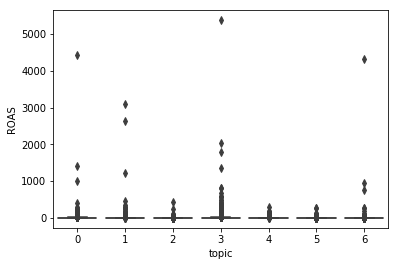

In [245]:
import seaborn as sns
sns.boxplot(x=result.topic, y=result.ROAS)

## Reporting

In [183]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel

c:\users\chris boulos\anaconda3\envs\tf\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6       7.667102  25.699001       1        1  17.919638
0     -76.859024 -27.943039       2        1  16.423658
3     -19.109671 -25.521587       3        1  15.309032
5     -45.885784 -76.744301       4        1  14.167529
2      38.636009 -23.100197       5        1  13.332768
4      11.860767 -74.318604       6        1  12.751108
1     -50.079781  23.279654       7        1  10.096267, topic_info=     Category        Freq               Term        Total  loglift  logprob
term                                                                       
75    Default  568.000000            details   568.000000  30.0000  30.0000
319   Default  874.000000              today   874.000000  29.0000  29.0000
118   Default  952.000000                get   952.000000  28.0000  28.0000
294   Default  463.000000              style   463.000000  27.0000  27.0000
202   Default  642.000000                one   642.000000  26.0000  26.0000
310   Default  453.000000          test time   453.000000  25.0000  25.0000
124   Default  440.000000          get today   440.000000  24.0000  24.0000
309   Default  453.000000               test   453.000000  23.0000  23.0000
290   Default  447.000000              stand   447.000000  22.0000  22.0000
291   Default  446.000000         stand test   446.000000  21.0000  21.0000
168   Default  329.000000               love   329.000000  20.0000  20.0000
295   Default  378.000000      style details   378.000000  19.0000  19.0000
314   Default  632.000000               time   632.000000  18.0000  18.0000
302   Default  273.000000             symbol   273.000000  17.0000  17.0000
114   Default  509.000000               free   509.000000  16.0000  16.0000
278   Default  506.000000           shipping   506.000000  15.0000  15.0000
60    Default  258.000000         commitment   258.000000  14.0000  14.0000
303   Default  258.000000        symbol love   258.000000  13.0000  13.0000
169   Default  254.000000    love commitment   254.000000  12.0000  12.0000
11    Default  550.000000             anchor   550.000000  11.0000  11.0000
165   Default  240.000000               look   240.000000  10.0000  10.0000
301   Default  278.000000       sweden stand   278.000000   9.0000   9.0000
348   Default  239.000000          worldwide   239.000000   8.0000   8.0000
276   Default  202.000000              share   202.000000   7.0000   7.0000
67    Default  235.000000           courtesy   235.000000   6.0000   6.0000
26    Default  261.000000              black   261.000000   5.0000   5.0000
300   Default  471.000000             sweden   471.000000   4.0000   4.0000
268   Default  231.000000                see   231.000000   3.0000   3.0000
175   Default  214.000000               make   214.000000   2.0000   2.0000
223   Default  307.000000              photo   307.000000   1.0000   1.0000
...       ...         ...                ...          ...      ...      ...
277    Topic7  134.351846       share symbol   135.236427   2.2864  -3.3609
5      Topic7   77.109876             access    77.981366   2.2818  -3.9161
86     Topic7   77.109297              early    77.982765   2.2817  -3.9161
87     Topic7   77.109273       early access    77.982827   2.2817  -3.9161
62     Topic7   71.194040   commitment visit    72.065232   2.2808  -3.9959
282    Topic7   56.422135               sign    57.310473   2.2774  -4.2285
279    Topic7   55.894239   shipping returns    56.813419   2.2767  -4.2379
15     Topic7   81.960040      anchor symbol    83.415661   2.2754  -3.8551
144    Topic7   47.200377       holiday gift    48.209588   2.2718  -4.4069
126    Topic7   41.007109         gift order    41.929411   2.2708  -4.5476
218    Topic7   48.189420    perfect holiday    49.275143   2.2707  -4.3862
201    Topic7   36.533832             offers    37.413507   2.2692  -4.6631
99     Topic7   35.152826   exclu

In [1300]:
resultConvs.Body[151:200]

602    Handcrafted in Sweden to stand the test of tim...
605           Get your favorite Tom Hope bracelet today.
608    Handcrafted in Sweden to stand the test of tim...
611    Handcrafted in Sweden to stand the test of tim...
615     Handcrafted in Sweden to stand the test of time.
618    Handcrafted in Sweden to stand the test of tim...
620    Handcrafted in Sweden to stand the test of tim...
622           Get your favorite Tom Hope bracelet today.
626    Handcrafted in Sweden to stand the test of tim...
633    Handcrafted in Sweden to stand the test of tim...
634    Handcrafted in Sweden to stand the test of tim...
637    Handcrafted in Sweden to stand the test of tim...
643           Get your favorite Tom Hope bracelet today.
644     Handcrafted in Sweden to stand the test of time.
647    Find your favorite Tom Hope bracelet today. St...
649    Find your favorite Tom Hope bracelet today. St...
654           Get your favorite Tom Hope bracelet today.
657    Handcrafted in Sweden to

In [1316]:
resultConvs.topic[100:200]

404    4
411    4
415    5
416    5
418    5
420    5
428    3
430    3
434    3
435    3
441    3
442    6
446    3
447    3
449    3
451    3
458    6
461    3
470    1
472    1
475    5
477    5
486    3
489    3
494    3
507    1
509    1
517    1
522    1
527    1
      ..
663    3
664    6
665    3
666    4
667    4
671    3
674    3
675    3
676    6
680    4
681    3
685    3
689    3
698    3
709    0
711    4
712    4
713    4
714    4
716    3
722    4
725    3
729    4
732    4
735    1
740    4
743    1
745    4
748    4
751    4
Name: topic, Length: 100, dtype: int64

In [1321]:
print(resultConvs.Body[735],
resultConvs.topic[735])

Style is in the details. Take a closer look at the brand new Triple Black collection. Order today for free shipping. Visit www.thetomhope.com 1


In [587]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 5
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
test time test stand stand test time
Topic 1:
love symbol commitment symbol love love commitment
Topic 2:
one get make visit sure
Topic 3:
details style style details anchor see
Topic 4:
look courtesy visit photo take
Topic 5:
today get get today free shipping
Topic 6:
new black triple triple black today


# Bringing in Images

### Using generic json approach

In [701]:
my_app_id = '1702677713160224'
THacct = 'act_347596444'
field='image_url'
access_token='EAAYMk4xCiCABAB8h1VVTpjjhjzfIqGfwI8Vm4aSc5BDfm3ipghZAK3NrnGXZAqKB5ZCu4YsAnP0CF1AcZA9CKTLE2wO4w2gKnBYEKLG79JoVuViSVCsRhXwFg0yVCrWDGpHKmtZAt24FatEa1ZCAEjiiHE0sl8Yo7LYBsxfuOhCOTNOQHklwHZBcKOWxTbjl93PzN65TenEZBzfwiGhmL1Mg'
URL ="https://graph.facebook.com/v3.1/act_347596444?fields=ads.limit(1000)%7Badcreatives%7Bimage_url%7D%7D&access_token="

In [592]:
def pp(o):
    all_ads = []
    if ('data' in o):
        for ad in o:
            if ('next' in ad['paging']):
                resp = request.get(ad['paging']['next'])
                all_ads.append(resp.json())
            elif ('after' in ad['paging']['cursors']):
                new_url = URL + ad['paging']['cursors']['after']
                resp = request.get(new_url)
                all_ads.append(resp.json())
            else:
                print("Something went wrong")
    with open('facebook.txt', 'a') as f:
        json.dump(o, f, indent=4)

In [608]:
#to search within JSON for a key
def _finditem(obj, key):
    if key in obj: return obj[key]
    for k, v in obj.items():
        if isinstance(v,dict):
            item = _finditem(v, key)
            if item is not None:
                return item

In [694]:
#to call Facebook API for info
def get_data(fpath, token):
    r = requests.get(f"{fpath}{token}")
    data = json.loads(r.text)
    f = open("output.txt", "a")
    f.write(json.dumps(data, indent=4))
    f.write('\n')
    while _finditem(data, 'next') != None:
    #for i in (0,3):
        r = requests.get(_finditem(data, 'next'))
        data = json.loads(r.text)
        f.write(json.dumps(data, indent=4))
        f.write('\n')
    print('json file has been generated')
    f.close()
    return data    
    

In [705]:
response=requests.get(f"{URL}{access_token}").json()

In [722]:
json_normalize(response['ads']['data'])

AttributeError: 'DataFrame' object has no attribute 'adcreatives'

In [700]:
with open('creat_p1.json','r') as f:
    d = json.load(f)

JSONDecodeError: Extra data: line 10438 column 1 (char 255718)

In [695]:
dat = get_data(URL,access_token)

AttributeError: 'dict' object has no attribute 'text'

In [699]:
f.write('\n')

1

In [650]:
r = requests.get(f"{URL}{access_token}")

In [661]:
dat = json.loads(r.text)

## Facebook SDK

In [599]:
my_app_id = '1702677713160224'
my_app_secret = "f484ff69b8f996f807fdbbab899f94cb"
my_token = 'EAAYMk4xCiCABAO4kSRj3ZB1xAgJfzkvb0Ix4m0w45ogtXsLNEKgm9j1igsdtcqGHBhBnpzlWYTXax58LS4VG9C4mLBCZBhWifPdN54o1oYRMO9w1Ewkjwn5JAIY0a2F4cAmX1GBcV96T74MzNWHdRNeX9ufYHDRX8B2bt1u6SnJ9nMhx4lOm05iEqyu6SGZAXcxAMBZBnHY6zpHpDgRW'

In [602]:
FacebookAdsApi.init(my_app_id, my_app_secret, my_token)
my_account = AdAccount('act_347596444')
me = my_account.get_users()
ads = my_account.get_ads(fields=[Ad.Field.creative])

In [606]:
for ad in ads:
    print(ad[Ad.Field.creative])

<AdCreative> {
    "creative_id": "6099789726747",
    "id": "6099789726747"
}
<AdCreative> {
    "creative_id": "6099787415547",
    "id": "6099787415547"
}
<AdCreative> {
    "creative_id": "6099699686147",
    "id": "6099699686147"
}
<AdCreative> {
    "creative_id": "6097785456347",
    "id": "6097785456347"
}
<AdCreative> {
    "creative_id": "6098349350347",
    "id": "6098349350347"
}
<AdCreative> {
    "creative_id": "6097786967747",
    "id": "6097786967747"
}
<AdCreative> {
    "creative_id": "6098109252147",
    "id": "6098109252147"
}
<AdCreative> {
    "creative_id": "6098109252147",
    "id": "6098109252147"
}
<AdCreative> {
    "creative_id": "6099615327147",
    "id": "6099615327147"
}
<AdCreative> {
    "creative_id": "6099637623947",
    "id": "6099637623947"
}
<AdCreative> {
    "creative_id": "6099336208347",
    "id": "6099336208347"
}
<AdCreative> {
    "creative_id": "6099335837747",
    "id": "6099335837747"
}
<AdCreative> {
    "creative_id": "6099336208347",
 

}
<AdCreative> {
    "creative_id": "6099343347347",
    "id": "6099343347347"
}
<AdCreative> {
    "creative_id": "6099343349147",
    "id": "6099343349147"
}
<AdCreative> {
    "creative_id": "6099346096947",
    "id": "6099346096947"
}
<AdCreative> {
    "creative_id": "6099346096947",
    "id": "6099346096947"
}
<AdCreative> {
    "creative_id": "6099343347347",
    "id": "6099343347347"
}
<AdCreative> {
    "creative_id": "6099343347347",
    "id": "6099343347347"
}
<AdCreative> {
    "creative_id": "6099345870747",
    "id": "6099345870747"
}
<AdCreative> {
    "creative_id": "6099345871947",
    "id": "6099345871947"
}
<AdCreative> {
    "creative_id": "6099343347347",
    "id": "6099343347347"
}
<AdCreative> {
    "creative_id": "6099346096947",
    "id": "6099346096947"
}
<AdCreative> {
    "creative_id": "6099541021547",
    "id": "6099541021547"
}
<AdCreative> {
    "creative_id": "6099540998747",
    "id": "6099540998747"
}
<AdCreative> {
    "creative_id": "6099345870547",

}
<AdCreative> {
    "creative_id": "6099343544547",
    "id": "6099343544547"
}
<AdCreative> {
    "creative_id": "6099343350747",
    "id": "6099343350747"
}
<AdCreative> {
    "creative_id": "6099345730347",
    "id": "6099345730347"
}
<AdCreative> {
    "creative_id": "6099345730347",
    "id": "6099345730347"
}
<AdCreative> {
    "creative_id": "6099343350747",
    "id": "6099343350747"
}
<AdCreative> {
    "creative_id": "6099343544547",
    "id": "6099343544547"
}
<AdCreative> {
    "creative_id": "6099343350747",
    "id": "6099343350747"
}
<AdCreative> {
    "creative_id": "6099345730347",
    "id": "6099345730347"
}
<AdCreative> {
    "creative_id": "6099345730347",
    "id": "6099345730347"
}
<AdCreative> {
    "creative_id": "6099345730347",
    "id": "6099345730347"
}
<AdCreative> {
    "creative_id": "6099343544547",
    "id": "6099343544547"
}
<AdCreative> {
    "creative_id": "6099345730347",
    "id": "6099345730347"
}
<AdCreative> {
    "creative_id": "6097856837547",

}
<AdCreative> {
    "creative_id": "6095365196747",
    "id": "6095365196747"
}
<AdCreative> {
    "creative_id": "6098946594747",
    "id": "6098946594747"
}
<AdCreative> {
    "creative_id": "6098518001547",
    "id": "6098518001547"
}
<AdCreative> {
    "creative_id": "6098628771947",
    "id": "6098628771947"
}
<AdCreative> {
    "creative_id": "6098328832547",
    "id": "6098328832547"
}
<AdCreative> {
    "creative_id": "6098704953747",
    "id": "6098704953747"
}
<AdCreative> {
    "creative_id": "6098704958147",
    "id": "6098704958147"
}
<AdCreative> {
    "creative_id": "6098704937947",
    "id": "6098704937947"
}
<AdCreative> {
    "creative_id": "6098423594147",
    "id": "6098423594147"
}
<AdCreative> {
    "creative_id": "6097856837547",
    "id": "6097856837547"
}
<AdCreative> {
    "creative_id": "6095141080147",
    "id": "6095141080147"
}
<AdCreative> {
    "creative_id": "6098130622147",
    "id": "6098130622147"
}
<AdCreative> {
    "creative_id": "6097614589947",

}
<AdCreative> {
    "creative_id": "6095141080147",
    "id": "6095141080147"
}
<AdCreative> {
    "creative_id": "6094298076547",
    "id": "6094298076547"
}
<AdCreative> {
    "creative_id": "6095143488747",
    "id": "6095143488747"
}
<AdCreative> {
    "creative_id": "6095142310347",
    "id": "6095142310347"
}
<AdCreative> {
    "creative_id": "6095140682147",
    "id": "6095140682147"
}
<AdCreative> {
    "creative_id": "6095142310147",
    "id": "6095142310147"
}
<AdCreative> {
    "creative_id": "6095048019147",
    "id": "6095048019147"
}
<AdCreative> {
    "creative_id": "6094673758547",
    "id": "6094673758547"
}
<AdCreative> {
    "creative_id": "6094673529547",
    "id": "6094673529547"
}
<AdCreative> {
    "creative_id": "6074228710347",
    "id": "6074228710347"
}
<AdCreative> {
    "creative_id": "6094585165947",
    "id": "6094585165947"
}
<AdCreative> {
    "creative_id": "6094544106947",
    "id": "6094544106947"
}
<AdCreative> {
    "creative_id": "6094544106947",

}
<AdCreative> {
    "creative_id": "6092445721147",
    "id": "6092445721147"
}
<AdCreative> {
    "creative_id": "6092443721547",
    "id": "6092443721547"
}
<AdCreative> {
    "creative_id": "6092444168147",
    "id": "6092444168147"
}
<AdCreative> {
    "creative_id": "6092443721547",
    "id": "6092443721547"
}
<AdCreative> {
    "creative_id": "6092443721547",
    "id": "6092443721547"
}
<AdCreative> {
    "creative_id": "6092444168147",
    "id": "6092444168147"
}
<AdCreative> {
    "creative_id": "6092443074147",
    "id": "6092443074147"
}
<AdCreative> {
    "creative_id": "6092443721547",
    "id": "6092443721547"
}
<AdCreative> {
    "creative_id": "6092444168147",
    "id": "6092444168147"
}
<AdCreative> {
    "creative_id": "6092444168147",
    "id": "6092444168147"
}
<AdCreative> {
    "creative_id": "6092427084747",
    "id": "6092427084747"
}
<AdCreative> {
    "creative_id": "6092070988547",
    "id": "6092070988547"
}
<AdCreative> {
    "creative_id": "6092398319947",

}
<AdCreative> {
    "creative_id": "6086618287347",
    "id": "6086618287347"
}
<AdCreative> {
    "creative_id": "6086618646947",
    "id": "6086618646947"
}
<AdCreative> {
    "creative_id": "6086618591347",
    "id": "6086618591347"
}
<AdCreative> {
    "creative_id": "6086618360547",
    "id": "6086618360547"
}
<AdCreative> {
    "creative_id": "6086618297947",
    "id": "6086618297947"
}
<AdCreative> {
    "creative_id": "6086618618147",
    "id": "6086618618147"
}
<AdCreative> {
    "creative_id": "6086618433347",
    "id": "6086618433347"
}
<AdCreative> {
    "creative_id": "6086618684547",
    "id": "6086618684547"
}
<AdCreative> {
    "creative_id": "6086618601347",
    "id": "6086618601347"
}
<AdCreative> {
    "creative_id": "6086618584147",
    "id": "6086618584147"
}
<AdCreative> {
    "creative_id": "6086618740747",
    "id": "6086618740747"
}
<AdCreative> {
    "creative_id": "6086618540547",
    "id": "6086618540547"
}
<AdCreative> {
    "creative_id": "6086618513347",

}
<AdCreative> {
    "creative_id": "6089235155347",
    "id": "6089235155347"
}
<AdCreative> {
    "creative_id": "6089467668947",
    "id": "6089467668947"
}
<AdCreative> {
    "creative_id": "6089467655147",
    "id": "6089467655147"
}
<AdCreative> {
    "creative_id": "6089467655947",
    "id": "6089467655947"
}
<AdCreative> {
    "creative_id": "6089467655547",
    "id": "6089467655547"
}
<AdCreative> {
    "creative_id": "6089467655747",
    "id": "6089467655747"
}
<AdCreative> {
    "creative_id": "6089467655347",
    "id": "6089467655347"
}
<AdCreative> {
    "creative_id": "6089467694147",
    "id": "6089467694147"
}
<AdCreative> {
    "creative_id": "6089467668347",
    "id": "6089467668347"
}
<AdCreative> {
    "creative_id": "6089467700147",
    "id": "6089467700147"
}
<AdCreative> {
    "creative_id": "6089467669147",
    "id": "6089467669147"
}
<AdCreative> {
    "creative_id": "6089467668747",
    "id": "6089467668747"
}
<AdCreative> {
    "creative_id": "6089467689747",

}
<AdCreative> {
    "creative_id": "6088218610347",
    "id": "6088218610347"
}
<AdCreative> {
    "creative_id": "6087738632947",
    "id": "6087738632947"
}
<AdCreative> {
    "creative_id": "6087738656147",
    "id": "6087738656147"
}
<AdCreative> {
    "creative_id": "6087738634747",
    "id": "6087738634747"
}
<AdCreative> {
    "creative_id": "6087738633347",
    "id": "6087738633347"
}
<AdCreative> {
    "creative_id": "6087738633547",
    "id": "6087738633547"
}
<AdCreative> {
    "creative_id": "6088297380347",
    "id": "6088297380347"
}
<AdCreative> {
    "creative_id": "6087738632147",
    "id": "6087738632147"
}
<AdCreative> {
    "creative_id": "6088297417947",
    "id": "6088297417947"
}
<AdCreative> {
    "creative_id": "6088297214147",
    "id": "6088297214147"
}
<AdCreative> {
    "creative_id": "6067551849947",
    "id": "6067551849947"
}
<AdCreative> {
    "creative_id": "6088559329547",
    "id": "6088559329547"
}
<AdCreative> {
    "creative_id": "6088559329547",

}
<AdCreative> {
    "creative_id": "6087515959547",
    "id": "6087515959547"
}
<AdCreative> {
    "creative_id": "6087368880747",
    "id": "6087368880747"
}
<AdCreative> {
    "creative_id": "6087298803747",
    "id": "6087298803747"
}
<AdCreative> {
    "creative_id": "6086616332547",
    "id": "6086616332547"
}
<AdCreative> {
    "creative_id": "6087047792347",
    "id": "6087047792347"
}
<AdCreative> {
    "creative_id": "6086869316347",
    "id": "6086869316347"
}
<AdCreative> {
    "creative_id": "6086616592947",
    "id": "6086616592947"
}
<AdCreative> {
    "creative_id": "6087231867947",
    "id": "6087231867947"
}
<AdCreative> {
    "creative_id": "6086616282347",
    "id": "6086616282347"
}
<AdCreative> {
    "creative_id": "6086616170147",
    "id": "6086616170147"
}
<AdCreative> {
    "creative_id": "6086869297547",
    "id": "6086869297547"
}
<AdCreative> {
    "creative_id": "6086869286347",
    "id": "6086869286347"
}
<AdCreative> {
    "creative_id": "6087231874747",

}
<AdCreative> {
    "creative_id": "6086618590147",
    "id": "6086618590147"
}
<AdCreative> {
    "creative_id": "6086618349747",
    "id": "6086618349747"
}
<AdCreative> {
    "creative_id": "6086618567147",
    "id": "6086618567147"
}
<AdCreative> {
    "creative_id": "6086619143347",
    "id": "6086619143347"
}
<AdCreative> {
    "creative_id": "6086618414547",
    "id": "6086618414547"
}
<AdCreative> {
    "creative_id": "6086617706747",
    "id": "6086617706747"
}
<AdCreative> {
    "creative_id": "6086619085347",
    "id": "6086619085347"
}
<AdCreative> {
    "creative_id": "6086617770547",
    "id": "6086617770547"
}
<AdCreative> {
    "creative_id": "6086618153347",
    "id": "6086618153347"
}
<AdCreative> {
    "creative_id": "6086617716947",
    "id": "6086617716947"
}
<AdCreative> {
    "creative_id": "6086618379947",
    "id": "6086618379947"
}
<AdCreative> {
    "creative_id": "6086618356347",
    "id": "6086618356347"
}
<AdCreative> {
    "creative_id": "6086618611147",

}
<AdCreative> {
    "creative_id": "6086103828947",
    "id": "6086103828947"
}
<AdCreative> {
    "creative_id": "6083483285347",
    "id": "6083483285347"
}
<AdCreative> {
    "creative_id": "6086094705347",
    "id": "6086094705347"
}
<AdCreative> {
    "creative_id": "6086094700347",
    "id": "6086094700347"
}
<AdCreative> {
    "creative_id": "6086093617947",
    "id": "6086093617947"
}
<AdCreative> {
    "creative_id": "6086093614347",
    "id": "6086093614347"
}
<AdCreative> {
    "creative_id": "6086093587747",
    "id": "6086093587747"
}
<AdCreative> {
    "creative_id": "6086039556747",
    "id": "6086039556747"
}
<AdCreative> {
    "creative_id": "6086032134547",
    "id": "6086032134547"
}
<AdCreative> {
    "creative_id": "6085866500347",
    "id": "6085866500347"
}
<AdCreative> {
    "creative_id": "6085866497147",
    "id": "6085866497147"
}
<AdCreative> {
    "creative_id": "6085851258947",
    "id": "6085851258947"
}
<AdCreative> {
    "creative_id": "6085851251347",

}
<AdCreative> {
    "creative_id": "6083266362347",
    "id": "6083266362347"
}
<AdCreative> {
    "creative_id": "6083031966547",
    "id": "6083031966547"
}
<AdCreative> {
    "creative_id": "6082498539147",
    "id": "6082498539147"
}
<AdCreative> {
    "creative_id": "6083273145747",
    "id": "6083273145747"
}
<AdCreative> {
    "creative_id": "6082744877147",
    "id": "6082744877147"
}
<AdCreative> {
    "creative_id": "6082845341747",
    "id": "6082845341747"
}
<AdCreative> {
    "creative_id": "6082810487747",
    "id": "6082810487747"
}
<AdCreative> {
    "creative_id": "6083404637147",
    "id": "6083404637147"
}
<AdCreative> {
    "creative_id": "6083291078147",
    "id": "6083291078147"
}
<AdCreative> {
    "creative_id": "6083384754147",
    "id": "6083384754147"
}
<AdCreative> {
    "creative_id": "6082626321947",
    "id": "6082626321947"
}
<AdCreative> {
    "creative_id": "6083340643547",
    "id": "6083340643547"
}
<AdCreative> {
    "creative_id": "6083266341747",

}
<AdCreative> {
    "creative_id": "6083110776547",
    "id": "6083110776547"
}
<AdCreative> {
    "creative_id": "6082536921147",
    "id": "6082536921147"
}
<AdCreative> {
    "creative_id": "6082701647347",
    "id": "6082701647347"
}
<AdCreative> {
    "creative_id": "6082833567947",
    "id": "6082833567947"
}
<AdCreative> {
    "creative_id": "6082644607547",
    "id": "6082644607547"
}
<AdCreative> {
    "creative_id": "6082371675147",
    "id": "6082371675147"
}
<AdCreative> {
    "creative_id": "6082816577947",
    "id": "6082816577947"
}
<AdCreative> {
    "creative_id": "6082677501547",
    "id": "6082677501547"
}
<AdCreative> {
    "creative_id": "6082702078747",
    "id": "6082702078747"
}
<AdCreative> {
    "creative_id": "6082701976147",
    "id": "6082701976147"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6082536659347",
    "id": "6082536659347"
}
<AdCreative> {
    "creative_id": "6082645976547",

}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6080495608747",
    "id": "6080495608747"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6080495608747",
    "id": "6080495608747"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6080495608747",
    "id": "6080495608747"
}
<AdCreative> {
    "creative_id": "6080495608747",
    "id": "6080495608747"
}
<AdCreative> {
    "creative_id": "6081306277347",
    "id": "6081306277347"
}
<AdCreative> {
    "creative_id": "6081300949547",
    "id": "6081300949547"
}
<AdCreative> {
    "creative_id": "6080495608747",
    "id": "6080495608747"
}
<AdCreative> {
    "creative_id": "6080900503147",
    "id": "6080900503147"
}
<AdCreative> {
    "creative_id": "6081306245547",
    "id": "6081306245547"
}
<AdCreative> {
    "creative_id": "6081324251147",

}
<AdCreative> {
    "creative_id": "6080495608747",
    "id": "6080495608747"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6081306245547",
    "id": "6081306245547"
}
<AdCreative> {
    "creative_id": "6080900503147",
    "id": "6080900503147"
}
<AdCreative> {
    "creative_id": "6080495608747",
    "id": "6080495608747"
}
<AdCreative> {
    "creative_id": "6081306277347",
    "id": "6081306277347"
}
<AdCreative> {
    "creative_id": "6080900503147",
    "id": "6080900503147"
}
<AdCreative> {
    "creative_id": "6081306277347",
    "id": "6081306277347"
}
<AdCreative> {
    "creative_id": "6080495608747",
    "id": "6080495608747"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6081306245547",
    "id": "6081306245547"
}
<AdCreative> {
    "creative_id": "6080495608747",

}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6080722455347",
    "id": "6080722455347"
}
<AdCreative> {
    "creative_id": "6081331426547",
    "id": "6081331426547"
}
<AdCreative> {
    "creative_id": "6081324251147",
    "id": "6081324251147"
}
<AdCreative> {
    "creative_id": "6080777731747",
    "id": "6080777731747"
}
<AdCreative> {
    "creative_id": "6080973673747",
    "id": "6080973673747"
}
<AdCreative> {
    "creative_id": "6081160667147",

}
<AdCreative> {
    "creative_id": "6079454828147",
    "id": "6079454828147"
}
<AdCreative> {
    "creative_id": "6079454811147",
    "id": "6079454811147"
}
<AdCreative> {
    "creative_id": "6079454815347",
    "id": "6079454815347"
}
<AdCreative> {
    "creative_id": "6079454817347",
    "id": "6079454817347"
}
<AdCreative> {
    "creative_id": "6079454839547",
    "id": "6079454839547"
}
<AdCreative> {
    "creative_id": "6079454841547",
    "id": "6079454841547"
}
<AdCreative> {
    "creative_id": "6079454835947",
    "id": "6079454835947"
}
<AdCreative> {
    "creative_id": "6079454829747",
    "id": "6079454829747"
}
<AdCreative> {
    "creative_id": "6080348652147",
    "id": "6080348652147"
}
<AdCreative> {
    "creative_id": "6079537183147",
    "id": "6079537183147"
}
<AdCreative> {
    "creative_id": "6080348673147",
    "id": "6080348673147"
}
<AdCreative> {
    "creative_id": "6080206798947",
    "id": "6080206798947"
}
<AdCreative> {
    "creative_id": "6079203389947",

}
<AdCreative> {
    "creative_id": "6079322596947",
    "id": "6079322596947"
}
<AdCreative> {
    "creative_id": "6079535228747",
    "id": "6079535228747"
}
<AdCreative> {
    "creative_id": "6078793612347",
    "id": "6078793612347"
}
<AdCreative> {
    "creative_id": "6079086618347",
    "id": "6079086618347"
}
<AdCreative> {
    "creative_id": "6079476056147",
    "id": "6079476056147"
}
<AdCreative> {
    "creative_id": "6078864414347",
    "id": "6078864414347"
}
<AdCreative> {
    "creative_id": "6078864414347",
    "id": "6078864414347"
}
<AdCreative> {
    "creative_id": "6079455961147",
    "id": "6079455961147"
}
<AdCreative> {
    "creative_id": "6079455953547",
    "id": "6079455953547"
}
<AdCreative> {
    "creative_id": "6079455946347",
    "id": "6079455946347"
}
<AdCreative> {
    "creative_id": "6079455950747",
    "id": "6079455950747"
}
<AdCreative> {
    "creative_id": "6079455962147",
    "id": "6079455962147"
}
<AdCreative> {
    "creative_id": "6079455959147",

FacebookRequestError: 

  Message: Call was not successful
  Method:  GET
  Path:    https://graph.facebook.com/v3.0/act_347596444/ads?access_token=EAAYMk4xCiCABAO4kSRj3ZB1xAgJfzkvb0Ix4m0w45ogtXsLNEKgm9j1igsdtcqGHBhBnpzlWYTXax58LS4VG9C4mLBCZBhWifPdN54o1oYRMO9w1Ewkjwn5JAIY0a2F4cAmX1GBcV96T74MzNWHdRNeX9ufYHDRX8B2bt1u6SnJ9nMhx4lOm05iEqyu6SGZAXcxAMBZBnHY6zpHpDgRW&fields=creative&summary=true&limit=25&after=NjA3Nzg3NTc2Nzk0NwZDZD
  Params:  {'fields': 'creative', 'summary': 'true'}

  Status:  400
  Response:
    {
      "error": {
        "message": "(#17) User request limit reached",
        "type": "OAuthException",
        "is_transient": true,
        "code": 17,
        "fbtrace_id": "FBLnAittqhg"
      }
    }


## Using Cluster Data

In [3]:
images = pd.read_csv('./data/th_images/img_table.csv')

In [4]:
images

,Unnamed: 0,AdID,image_url,creative_id,image_id
0,1,6099339986547,https://scontent.xx.fbcdn.net/v/t45.1600-4/338...,6099340340147,1
1,2,6092960116547,https://scontent.xx.fbcdn.net/v/t45.1600-4/338...,6097866897147,1
2,24,6099891131347,https://scontent.xx.fbcdn.net/v/t45.1600-4/336...,6099896625547,2
3,27,6099891130147,https://scontent.xx.fbcdn.net/v/t45.1600-4/336...,6099896727747,2
4,28,6099891134347,https://scontent.xx.fbcdn.net/v/t45.1600-4/338...,6099896722547,1
5,30,6099891134147,https://scontent.xx.fbcdn.net/v/t45.1600-4/336...,6099896673347,2
6,31,6099891133147,https://scontent.xx.fbcdn.net/v/t45.1600-4/338...,6099896668347,1
7,32,6099891132747,https://scontent.xx.fbcdn.net/v/t45.1600-4/336...,6099896661147,2
8,36,6099891130347,https://scontent.xx.fbcdn.net/v/t45.1600-4/338...,6099896616947,1
9,37,6099891131147,https://scontent.xx.fbcdn.net/v/t45.1600-4/338...,6099896641747,1


In [5]:
groups = pd.read_csv('../aesth-test/aest-data/groups.csv',header=None)

In [6]:
groups

,0,1,2,3
0,NaN,group,path,0
1,0.0,2,E:\repos\projects\aesth-test\aest-data\THinsta...,1
2,1.0,1,E:\repos\projects\aesth-test\aest-data\THinsta...,2
3,2.0,3,E:\repos\projects\aesth-test\aest-data\THinsta...,3
4,3.0,3,E:\repos\projects\aesth-test\aest-data\THinsta...,4
5,4.0,1,E:\repos\projects\aesth-test\aest-data\THinsta...,5
6,5.0,4,E:\repos\projects\aesth-test\aest-data\THinsta...,6
7,6.0,2,E:\repos\projects\aesth-test\aest-data\THinsta...,7
8,7.0,3,E:\repos\projects\aesth-test\aest-data\THinsta...,8
9,8.0,3,E:\repos\projects\aesth-test\aest-data\THinsta...,9


In [35]:
groups.columns = ['image_id','group']

In [41]:
groups.image_id = groups.image_id+1

In [44]:
img_groups = pd.merge(images,groups, on='image_id')

In [102]:
rt_imgs = pd.merge(img_groups,rt_all, on='AdID')

In [138]:
pd.Series(rt_imgs.columns)

0                       Unnamed: 0
1                             AdID
2                        image_url
3                      creative_id
4                         image_id
5                            group
6                      Campaign ID
7                    Campaign Name
8                  Campaign Status
9               Campaign Objective
10                     Buying Type
11            Campaign Spend Limit
12           Campaign Daily Budget
13        Campaign Lifetime Budget
14           Campaign Bid Strategy
15                            Tags
16              Product Catalog ID
17                Campaign Page ID
18                       Ad Set ID
19               Ad Set Run Status
20     Ad Set Lifetime Impressions
21                     Ad Set Name
22               Ad Set Time Start
23                Ad Set Time Stop
24             Ad Set Daily Budget
25                Destination Type
26            Use Dynamic Creative
27          Ad Set Lifetime Budget
28                  

In [142]:
print((rt_imgs.groupby('group').mean().CTR_all/rt_imgs.CTR_all.mean())-1,
(rt_imgs.groupby('group').median().CTR_all/rt_imgs.CTR_all.median())-1)

group
0   -0.028491
1   -0.164048
2    0.370813
3    0.094127
4   -0.144068
Name: CTR_all, dtype: float64 group
0    0.051229
1   -0.222601
2    0.352865
3   -0.165320
4   -0.043561
Name: CTR_all, dtype: float64


In [141]:
print(1/(rt_imgs.groupby('group').mean().CostPerEngagement)/(1/(rt_imgs.CostPerEngagement.mean()))-1,
1/(rt_imgs.groupby('group').median().CostPerEngagement)/(1/(rt_imgs.CostPerEngagement.median()))-1)

group
0   -0.009198
1    0.280695
2   -0.231262
3    0.285416
4   -0.118739
Name: CostPerEngagement, dtype: float64 group
0   -0.080621
1    0.251022
2    0.231183
3   -0.019048
4   -0.260724
Name: CostPerEngagement, dtype: float64


In [137]:
print(1/(rt_imgs.groupby('group').mean().CPR)/(1/(rt_imgs.CPR.mean()))-1,
1/(rt_imgs.groupby('group').median().CPR)/(1/(rt_imgs.CPR.median()))-1)

group
0    0.274779
1   -0.124510
2   -0.380082
3    0.691130
4    0.212035
Name: CPR, dtype: float64 group
0   -0.107163
1   -0.044576
2   -0.450958
3    0.741145
4   -0.021753
Name: CPR, dtype: float64


In [121]:
print(rt_imgs.groupby('group').mean().CPR,
rt_imgs.groupby('group').median().CPR)

group
0     9.132264
1    13.297264
2    18.779286
3     6.883928
4     9.605020
Name: CPR, dtype: float64 group
0    1.686476
1    1.576000
2    2.742500
3    0.864804
4    1.539231
Name: CPR, dtype: float64
